In [5]:
from transformers import QuestionAnsweringPipeline, AutoAdapterModel, AutoModelWithHeads, AutoTokenizer, AutoConfig
from transformers.onnx import OnnxConfig, validate_model_outputs, export
from transformers.models.bert import BertOnnxConfig

import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType
from onnxruntime import InferenceSession
from onnx_opcounter import calculate_params

import os
import time
import torch
import numpy as np

from datasets import load_metric, load_dataset

from typing import Mapping, OrderedDict
from pathlib import Path

### Extractive QA (DROP BERT)

In [19]:
# Basic extractive QA Example
question = "What is Mary's job?"
context = "Thomas likes animals. Mary likes strawberry ice and is a physician"

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelWithHeads.from_pretrained("bert-base-uncased")
adapter_name = model.load_adapter("AdapterHub/bert-base-uncased-pf-drop", source="hf")
model.active_adapters = adapter_name

def base_model_inference(question, context):
    inputs = tokenizer(question, context, padding=True, truncation=True, return_tensors="pt")
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    start_idx = torch.argmax(outputs.start_logits, axis=1).numpy()[0]
    end_idx = (torch.argmax(outputs.end_logits, axis=1) + 1).numpy()[0]
    return tokenizer.decode(inputs['input_ids'][0, start_idx:end_idx])

answer = base_model_inference(question, context)
print(answer)

c:\Users\henninghof\.conda\envs\dasp\lib\site-packages\transformers\adapters\models\bert\adapter_model.py:250: FutureWarning: This class has been renamed to `BertAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(
c:\Users\henninghof\.conda\envs\dasp\lib\site-packages\transformers\adapters\models\bert\adapter_model.py:228: FutureWarning: This class has been renamed to `BertAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModelWithHeads: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are

physician


In [21]:
# Export to ONNX with custom config
class DropBertOnnxConfig(OnnxConfig):
    @property
    def inputs(self) -> Mapping[str, Mapping[int, str]]:
        if self.task == "multiple-choice":
            dynamic_axis = {0: "batch", 1: "choice", 2: "sequence"}
        else:
            dynamic_axis = {0: "batch", 1: "sequence"}
        return OrderedDict(
            [
                ("input_ids", dynamic_axis),
                ("attention_mask", dynamic_axis),
                ("token_type_ids", dynamic_axis),
            ]
        )

config = AutoConfig.from_pretrained("bert-base-uncased")
onnx_config = DropBertOnnxConfig(config, task="question-answering")

onnx_path = Path("onnx/dropbert/model.onnx")

onnx_inputs, onnx_outputs = export(tokenizer, model, onnx_config, onnx_config.default_onnx_opset, onnx_path)

onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

In [22]:
# ONNX model inference
def onnx_inference(onnx_path, question, context):
    onnx_model = InferenceSession(
        str(onnx_path), providers=["CPUExecutionProvider"]
    )

    inputs = tokenizer(question, context, padding=True, truncation=True, return_tensors="np")
    inputs = {key: np.array(inputs[key], dtype=np.int64) for key in inputs}
    outputs = onnx_model.run(input_feed=dict(inputs), output_names=None)

    start_scores = outputs[0]
    end_scores = outputs[1]
    ans_start = np.argmax(start_scores)
    ans_end = np.argmax(end_scores)+1
    return tokenizer.decode(inputs['input_ids'][0, ans_start:ans_end])

question = 'Where do I live?'
context = 'My name is Paul and I live next to Darmstadt'

answer = onnx_inference(onnx_path, question, context)
print(answer)

[CLS]


### Model Quantization

In [23]:
# Quantize base model
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/(1024*1024))
    os.remove('temp.p')

print_size_of_model(model)
print_size_of_model(quantized_model)

Size (MB): 421.1567621231079
Size (MB): 396.7129182815552


In [24]:
def quantize_onnx_model(onnx_model_path, quantized_model_path):
    quantize_dynamic(onnx_model_path,
                     quantized_model_path,
                     weight_type=QuantType.QInt8)

    print(f"Quantized model saved to:{quantized_model_path}")

quantize_onnx_model('onnx/dropbert/model.onnx', 'onnx/dropbert/model_quant.onnx')

print('ONNX full precision model size (MB):', os.path.getsize("onnx/dropbert/model.onnx")/(1024*1024))
print('ONNX quantized model size (MB):', os.path.getsize("onnx/dropbert/model_quant.onnx")/(1024*1024))

Ignore MatMul due to non constant B: /[/bert/encoder/layer.0/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.0/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.1/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.1/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.2/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.2/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.3/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.3/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.4/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.4/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.5/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.5/atten

In [13]:
print('Number of base model params:', model.num_parameters())

def count_params_onnx(model_path):
    onnx_model = onnx.load(model_path)
    params = calculate_params(onnx_model)
    return params

print("ONNX number of full precision model params:", count_params_onnx("onnx/dropbert/model.onnx"))
print("ONNX number of quantized model params:", count_params_onnx("onnx/dropbert/model_quant.onnx"))

Number of base model params: 110378306
ONNX number of full precision model params: 109788226
ONNX number of quantized model params: 109788758.0


### Measure Performance on Dataset

In [14]:
def run_n_times(func, model, inputs, n = 50): 
    st= time.time()
    for _ in range(n):
        func(model, inputs)
    et = time.time()

    avg_inference_time = 1000 * (et - st) / n
    # message = "Average inference time for %s (n=%d): %.2fms " % (desc, n, avg_inference_time)

    return avg_inference_time

def run_torch(model, inputs):
    with torch.no_grad():
        model(**inputs)

def run_onnx(qa_model, onnx_inputs):
    qa_model.run(output_names=["start_logits", "end_logits"], input_feed=dict(onnx_inputs))   

Input Length 5: 81.734 ms
Input Length 105: 195.462 ms
Input Length 205: 372.899 ms
Input Length 305: 625.227 ms
Input Length 405: 873.728 ms
Input Length 505: 1212.865 ms
Input Length 5: 28.140 ms
Input Length 105: 109.880 ms
Input Length 205: 221.116 ms
Input Length 305: 343.950 ms
Input Length 405: 461.334 ms
Input Length 505: 896.003 ms
Input Length 5: 13.792 ms
Input Length 105: 127.091 ms
Input Length 205: 174.852 ms
Input Length 305: 334.031 ms
Input Length 405: 375.748 ms
Input Length 505: 488.835 ms


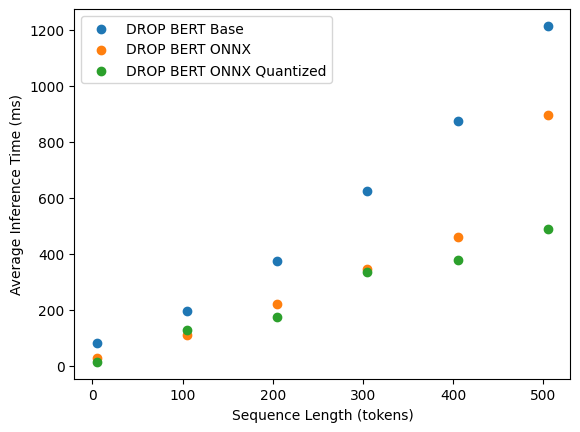

In [25]:
import matplotlib.pyplot as plt

def performance_seq_length(name, model):
    X = []
    time_measurements = []

    for i in range(6):
        context = (100*i+1)*"World "
        question = "Hello"

        inputs = tokenizer(question, context, return_tensors="np")
        inputs = {key: np.array(inputs[key], dtype=np.int64) for key in inputs}
        average_time = run_n_times(run_onnx, model, inputs)

        seq_length = 100*i+5
        print("Input Length {}: {:.3f} ms".format(seq_length, average_time))
        X.append(seq_length)
        time_measurements.append(average_time)

    plt.scatter(X, time_measurements, label=name)

def base_performance(name, model):
    X = []
    time_measurements = []

    for i in range(6):
        context = (100*i+1)*"World "
        question = "Hello"

        inputs = tokenizer(question, context, return_tensors="pt")
        average_time = run_n_times(run_torch, model, inputs)
        
        seq_length = 100*i+5 
        print("Input Length {}: {:.3f} ms".format(seq_length, average_time))
        X.append(seq_length)
        time_measurements.append(average_time)

    plt.scatter(X, time_measurements, label=name)


onnx_model = InferenceSession(
    "onnx/dropbert/model.onnx", providers=["CPUExecutionProvider"]
)

onnx_model_quant = InferenceSession(
    "onnx/dropbert/model_quant.onnx", providers=["CPUExecutionProvider"]
)

base_performance("DROP BERT Base", model)
performance_seq_length("DROP BERT ONNX", onnx_model)
performance_seq_length("DROP BERT ONNX Quantized", onnx_model_quant)

plt.xlabel("Sequence Length (tokens)")
plt.ylabel("Average Inference Time (ms)")
plt.legend()
plt.show()

### Multiple-Choice (CosmosQA BERT)

In [27]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = AutoModelWithHeads.from_pretrained("bert-base-uncased")
# adapter_name = model.load_adapter("AdapterHub/bert-base-uncased-pf-cosmos_qa", source="hf")
# model.active_adapters = adapter_name

# def mc_model_inference(question, context, choices):
#     outputs = []

#     raw_input = [[context, question + " " + choice] for choice in choices]
#     inputs = tokenizer(raw_input, padding=True, truncation=True, return_tensors="pt")

#     with torch.no_grad():
#         outputs = model(**inputs)

#     answer_idx = torch.argmax(outputs.logits)
#     return choices[answer_idx]

# question = "What animal has the most hair?"
# context = "Fish are typically not hairy. Cats have 10g of hair. Tigers have 50g of hair. Horses have 100g of hair."
# answer0 = "Tiger"
# answer1= "Cat"
# answer2= "Horse"
# answer3= "Fish"
# choices = [answer0, answer1, answer2, answer3]
# answer = mc_model_inference(question, context, choices)
# print(answer)

In [28]:
# config = AutoConfig.from_pretrained("bert-base-uncased")
# onnx_config = DropBertOnnxConfig(config, task="question-answering")

# onnx_path = Path("onnx/cosmosqabert/model.onnx")

# onnx_inputs, onnx_outputs = export(tokenizer, model, onnx_config, onnx_config.default_onnx_opset, onnx_path)

# onnx_model = onnx.load(onnx_path)
# onnx.checker.check_model(onnx_model)

In [29]:
# def onnx_inference(onnx_path, question, context, choices):
#     onnx_model = InferenceSession(
#         str(onnx_path), providers=["CPUExecutionProvider"]
#     )

#     raw_input = [[context, question + " " + choice] for choice in choices]
#     inputs = tokenizer(raw_input, padding=True, truncation=True, return_tensors="np")

#     outputs = onnx_model.run(input_feed=dict(inputs), output_names=None)

#     answer_idx = np.argmax(np.abs(np.sum(outputs[0], axis=1)))
#     return choices[answer_idx]

# answer = onnx_inference(onnx_path, question, context, choices)
# print(answer)